# Integrate scRNA-seq and CODEX data from bone marrow tissue for cell subtype prediction

Overview

This tutorial demostrates an example of integrating paired human bone marrow scRNA‑seq and CODEX data and adjudicate whether prediction disagreements reflect technical misannotations or genuine biological ambiguity.  

Outline
1. Data input
2. Data preprocessing
3. Cellink object construction and alignment
4. Cross-modality feature prediction and cell-subtype matching
5. Marker-based validation of conflicted populations
6. Biological ambiguity example

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
from cellink import Cellink
from cellink.utils import *

import requests
import os
import zipfile

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data input
Download count matrices, metadata, and spatial coordinates; construct AnnData objects for each modality retaining both `cell_type`  and `cell_subtype` labels.

In [2]:
#download bone marrow data
dropbox_url = "https://www.dropbox.com/scl/fo/12hj2cpqtip2rex87ponw/AF9cbZrBiKpx7Xs0Ng4TpVY?rlkey=e9bzrk3e89ea8vsbma4t5rdos&st=bn5y2kyf&dl=1"
response = requests.get(dropbox_url)
with open("bone_marrow_scrna_codex.zip", "wb") as f:
    f.write(response.content)

print("download success")

extract_dir = "unzipped_bone_marrow_scrna_codex"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile("bone_marrow_scrna_codex.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("unzipped data in:", extract_dir)

download success
unzipped data in: unzipped_bone_marrow_scrna_codex


In [3]:
scRNA = pd.read_csv('unzipped_bone_marrow_scrna_codex/scrna_count.csv')
CODEX = pd.read_csv('unzipped_bone_marrow_scrna_codex/codex_count.csv')
scRNA_meta = pd.read_csv('unzipped_bone_marrow_scrna_codex/scrna_metadata.csv')
CODEX_meta = pd.read_csv('unzipped_bone_marrow_scrna_codex/metadata.csv')

In [4]:
rna_feature = scRNA.iloc[:,0]
rna_obs = scRNA.columns[1:]
rna_mat = scRNA.iloc[:, 1:].to_numpy().T
# convert to anndata
rna_adata = ad.AnnData(rna_mat, dtype = np.float32)
rna_adata.var_names = rna_feature
rna_adata.obs_names = rna_obs

rna_adata.obs['cell_type'] = scRNA_meta['cluster_anno_coarse'].values
#rna_adata.obs['cell_type'] = scRNA_meta['cluster_anno_l2'].values
rna_adata.obs['cell_subtype'] = scRNA_meta['cluster_anno_l2'].values

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
protein_feature = CODEX.iloc[:,0]
protein_obs = CODEX.columns[1:]
protein_mat = CODEX.iloc[:, 1:].to_numpy().T
# convert to anndata
protein_adata = ad.AnnData(protein_mat, dtype = np.float32)
protein_adata.var_names = protein_feature
protein_adata.obs_names = protein_obs

protein_adata.obs['cell_type'] = CODEX_meta['cluster_anno_coarse'].values
protein_adata.obs['cell_subtype'] = CODEX_meta['cluster_anno_l2'].values

protein_adata.layers['counts'] = protein_adata.X.copy()

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
protein_adata.obsm['spatial'] = pd.DataFrame(CODEX_meta[['x.coord', 'y.coord']].values, index = protein_adata.obs_names, columns = ['X', 'Y'])

## Data preprocessing
Normalize & log-transform RNA counts, select highly variable genes, and harmonize subtype nomenclature. Produces consistent categorical labels for transfer accuracy and conflict detection.

In [7]:
# # process all RNA features
rna_adata.layers['counts'] = rna_adata.X.copy()
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# # only retain highly variable genes
rna_adata1 = rna_adata[:, rna_adata.var.highly_variable].copy()

if 'CD34' not in rna_adata1.var_names:
    # Extract the CD34 gene expression data from rna_adata
    cd34_data = rna_adata[:, 'CD34'].X
    
    # Create a new AnnData object with CD34 data
    cd34_adata = ad.AnnData(X=cd34_data, var=pd.DataFrame(index=['CD34']), obs=rna_adata1.obs)
    
    # Concatenate the CD34 data with rna_adata1 along the genes axis (columns)
    rna_adata1 = ad.concat([rna_adata1, cd34_adata], axis=1)
    
rna_adata1.obs = rna_adata.obs

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [8]:
def map_cell_types(cell_type):
    if cell_type in ['Adipo-MSC', 'THY1+ MSC']:
        return 'Mesenchymal'
    elif cell_type in ['VSMC']:
        return 'Muscle'
    elif cell_type in ['GMP', 'Monocytes', 'Monocyte', 'Macrophages']:
        return 'Myeloid'
    elif cell_type in ['CD8+ T-Cell', 'CD4+ T-Cell', 'Plasma Cell', 'Plasma Cells', 'CLP']:
        return 'Lymphoid'
    else:
        return cell_type

rna_adata1.obs['cell_type'] = rna_adata1.obs['cell_subtype'].apply(map_cell_types)
protein_adata.obs['cell_type'] = protein_adata.obs['cell_subtype'].apply(map_cell_types)

In [9]:
def map_cell_types(cell_type):
    if cell_type in ['Monocytes']:
        return 'Monocyte'
    elif cell_type in ['Plasma Cells']:
        return 'Plasma Cell'
    else:
        return cell_type

rna_adata1.obs['cell_subtype'] = rna_adata.obs['cell_subtype'].apply(map_cell_types)
protein_adata.obs['cell_subtype'] = protein_adata.obs['cell_subtype'].apply(map_cell_types)

## Cellink object construction and alignment
Derive gene–protein correspondence pairs, subset to shared features, filter for variance while forcing sentinel markers (CD8B, CD163, CD34), persist processed AnnData objects, then instantiate and run CelLink alignment (unbalanced OT with regularization) to obtain transport maps for subtype transfer and feature imputation.

In [ ]:
correspondence = pd.read_csv('/scratch/drjieliu_root/drjieliu/zchx/CelLink_tutorials/CelLink/docs/protein_gene_relationship.csv') #You cna get the csv file from the github repo of CelLink

In [11]:
rna_protein_correspondence = []
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata1.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [12]:
# correspondence information
protein_adata.var_names_make_unique()
rna_shared = rna_adata1[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
# Make sure no column is static
mask = (
    (rna_shared.X.std(axis=0) > 0.1) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
mask[np.where(rna_shared.var_names == "CD8B")[0][0]] = True
mask[np.where(protein_shared.var_names == "CD163")[0][0]] = True
mask[np.where(protein_shared.var_names == "CD34")[0][0]] = True
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(10000, 44), (10000, 44)]


/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
rna_adata1.write_h5ad('rna_adata.h5ad')
protein_adata.write_h5ad('protein_adata.h5ad')
rna_shared.write_h5ad('rna_shared.h5ad')
protein_shared.write_h5ad('protein_shared.h5ad')

In [15]:
rna_adata1 = sc.read_h5ad('rna_adata.h5ad')
protein_adata = sc.read_h5ad('protein_adata.h5ad')
rna_shared = sc.read_h5ad('rna_shared.h5ad')
protein_shared = sc.read_h5ad('protein_shared.h5ad')

/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfs/turbo/umms-drjieliu/usr/zchx/conda_envs/scarches/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Create a `Cellink` instance with full and shared AnnData objects, and optionally split data into batches for efficient processing. Below we show the alignment call with recommended parameter guidance.

In [16]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = rna_adata1, full_ann2 = protein_adata, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 10000, seed = 100)

Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 10000.
The second modality is split into 1 batches, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


Alignment key parameters and tuning guidance (with cell-type annotations)

- wt1, wt2: Graph smoothing shrinkage weights applied during the graph smoothing step. The smoothing result is computed as: wt * original_features + (1 - wt) * neighborhood_average. These weights control the relative importance of the center cell vs. neighborhood information. Typical values to try: 0.3, 0.5, 0.7, 1. Use lower wt (more smoothing) when data are noisy; use wt=1 to disable smoothing.You can try all of them to figure out which one is best.

- n_neighbors (K_Neighbourhood): Number of nearest neighbors used to build the KNN graph. The source code accepts this parameter when constructing graphs. Suggested defaults: 10 (recommended) or 15 for larger datasets. For very small datasets, use 5.

- reg: Entropic regularization coefficient used in unbalanced OT Sinkhorn. Controls the smoothness and effective sparsity of the transport matrix. Larger reg lead to smoother (less sparse) transport; smaller reg lead to sharper (more sparse) transport. Default: 0.01. Be cautious when setting drastically different reg values across modalities, as it may bias rows/columns to dominate.

- lambd: Entropic regularization coefficient used in balanced OT. It controls the overall transport loss and numerical behaviour. Setting lambd too low can harm convergence and lead to a drop in alignment accuracy. Default 0.01; change gradually and monitor convergence.

- sparse: When True, CelLink uses an LBFGS-based solver designed to produce sparser (near one-to-one) correspondences. This often yields crisper matches but is slower and can be numerically less stable on some datasets. When `sparse=False`, Sinkhorn-based dense solvers are used.

- iterative (bool) and numItermax: With `iterative=True`, CelLink runs the iterative unbalanced OT refinement stage (Stage II). When cell-type annotations are available, iterative refinement is recommended because the algorithm can leverage annotations to improve matching consistency across cell types. `numItermax` controls the Sinkhorn/LBFGS maximum iterations — increase it (for example to 1000 or more) if the solver emits convergence warnings.

- reg_m (tuple): KL-divergence mass regularization coefficients used by unbalanced Sinkhorn; tune when necessary to control mass deviation between modalities.

In [17]:
cellink.alignment(wt1 = 0.3, wt2 = 0.3, numItermax = 1000, reg = 0.005, 
                  reg_m1 = (40, 0.01), reg_m2 = (0.01, 40), iterative = True, sparse = False, BOT = False)

Now at batch 0<->0...
10000 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 97.42%! 

There are 258 unmatched samples and 9742 matched samples in data1!

10000 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 94.77%! 

There are 523 unmatched samples and 9477 matched samples in data2!



## Cross-modality feature prediction and cell-subtype matching
Perform bidirectional subtype transfer (RNA→Protein, Protein→RNA) using transport‑weight aggregation. Confusion matrices highlight on‑diagonal agreement and off‑diagonal conflict cohorts for marker-based adjudication.


In [18]:
ct_anno = []
protein_id = []
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    cell_id_rna = cellink.partition1[i]
    target_cell_types = rna_adata1.obs['cell_subtype'][cell_id_rna] # change into self
    for j in range(len(cell_id)):
        if j not in cellink.arr2_unmatched_cell_id[i]:
            weight_distribution = {}
            for target_cell_type in np.unique(target_cell_types):
                # Find indices of cells in the target dataset belonging to this cell type
                target_indices = np.where(target_cell_types == target_cell_type)[0]
                # Sum the weights in the transport map for these indices
                # This gives the total transport weight directed towards cells of this target cell type
                total_weight = cellink.cell_correspondence_partition2[i][j][target_indices].sum()
                # Store the total weight in the dictionary
                weight_distribution[target_cell_type] = total_weight

            sct = protein_adata.obs['cell_subtype'][cell_id[j]] # change into self
            pct = max(weight_distribution, key = weight_distribution.get)
            ct_anno.append([sct, pct])
            protein_id.append(cell_id[j])
            
ct_anno_df = pd.DataFrame(ct_anno, columns = ['sct', 'pct'])
sub = ct_anno_df.apply(lambda x: x['sct'] == x['pct'], axis=1)
sub.values.sum() / ct_anno_df.shape[0]

0.8147092961907777

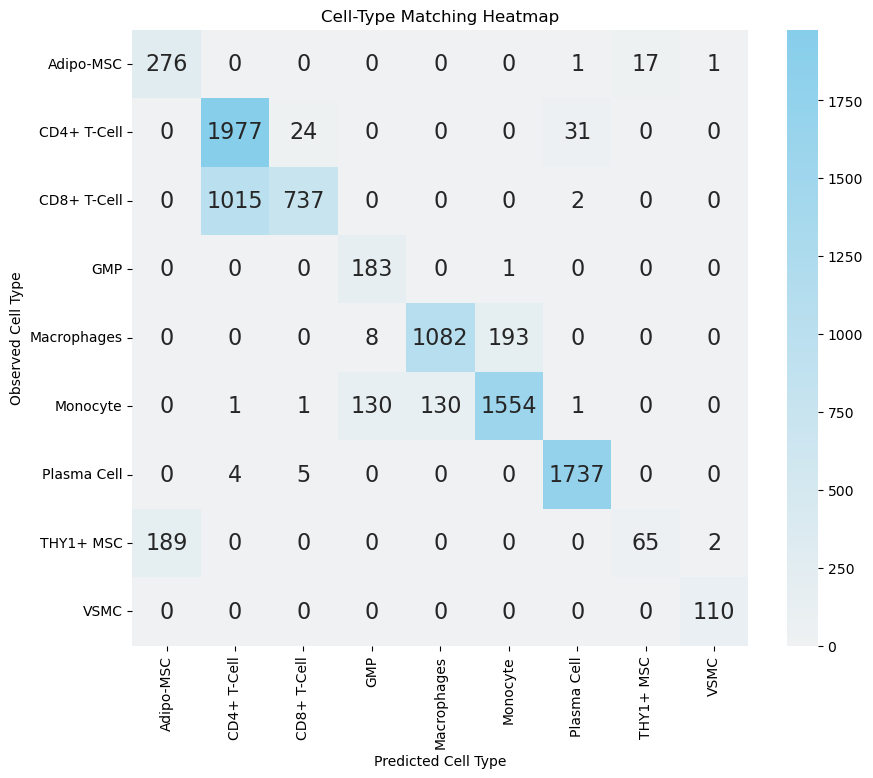

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
protein_source_ct_array = np.array(ct_anno_df['sct'])
protein_predict_ct_array = np.array(ct_anno_df['pct'])
cross_tab = pd.crosstab(ct_anno_df['sct'], ct_anno_df['pct'])
all_cell_types = sorted(list(set(np.unique(rna_adata1.obs['cell_subtype'].values))))
cross_tab = cross_tab.reindex(index=all_cell_types, columns=all_cell_types, fill_value=0)
# Plotting the heatmap
method_color = 'skyblue'  # CelLink method color
cmap = sns.light_palette(method_color, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap=cmap, annot_kws={"size": 16}, fmt='g', square=True)
plt.title('Cell-Type Matching Heatmap')
plt.xlabel('Predicted Cell Type')
plt.ylabel('Observed Cell Type')

plt.show()

In [21]:
ct_anno = []
rna_id = []
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    cell_id_protein = cellink.partition2[i]
    target_cell_types = protein_adata.obs['cell_subtype'][cell_id_protein] # change into self
    for j in range(len(cell_id)):
        if j not in cellink.arr1_unmatched_cell_id[i]:
            weight_distribution = {}
            for target_cell_type in np.unique(target_cell_types):
                # Find indices of cells in the target dataset belonging to this cell type
                target_indices = np.where(target_cell_types == target_cell_type)[0]
                # Sum the weights in the transport map for these indices
                # This gives the total transport weight directed towards cells of this target cell type
                total_weight = cellink.cell_correspondence_partition1[i][j][target_indices].sum()
                # Store the total weight in the dictionary
                weight_distribution[target_cell_type] = total_weight

            sct = rna_adata1.obs['cell_subtype'][cell_id[j]] # change into self
            pct = max(weight_distribution, key = weight_distribution.get)
            ct_anno.append([sct, pct])
            rna_id.append(cell_id[j])
ct_anno_df = pd.DataFrame(ct_anno, columns = ['sct', 'pct'])
sub = ct_anno_df.apply(lambda x: x['sct'] == x['pct'], axis=1)
sub.values.sum() / ct_anno_df.shape[0]

0.8001437076575652

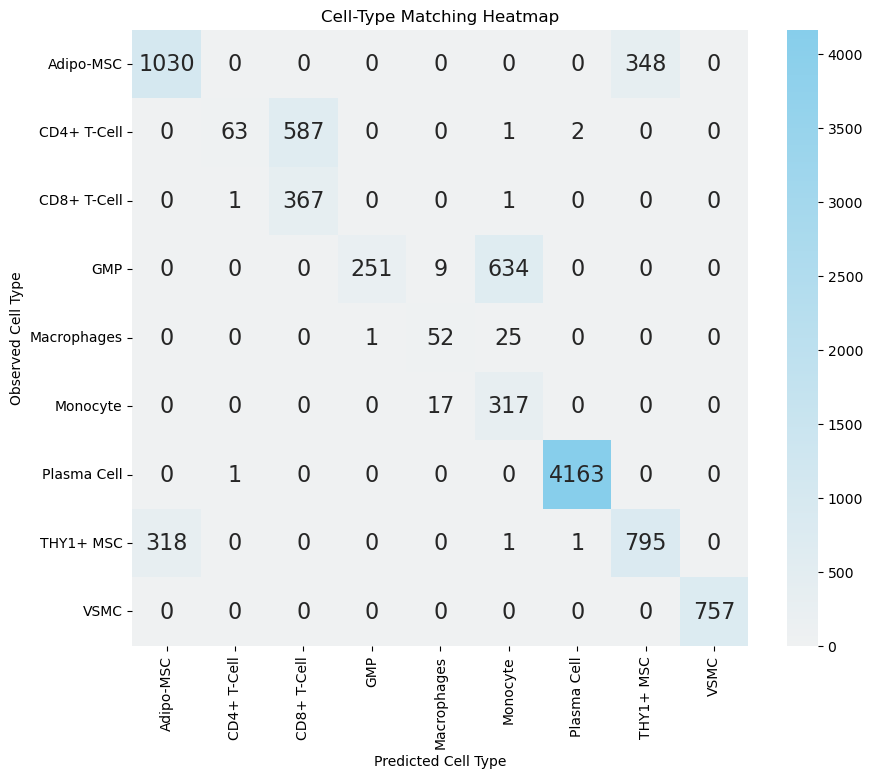

In [22]:
import seaborn as sns
rna_source_ct_array = np.array(ct_anno_df['sct'])
rna_predict_ct_array = np.array(ct_anno_df['pct'])
cross_tab = pd.crosstab(ct_anno_df['sct'], ct_anno_df['pct'])
all_cell_types = sorted(list(set(np.unique(rna_adata1.obs['cell_subtype'].values))))
# Plotting the heatmap
method_color = 'skyblue'  # CelLink method color
cmap = sns.light_palette(method_color, as_cmap=True)
cross_tab = cross_tab.reindex(index=all_cell_types, columns=all_cell_types, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap=cmap, annot_kws={"size": 16}, fmt='g', square=True)
plt.title('Cell-Type Matching Heatmap')
plt.xlabel('Predicted Cell Type')
plt.ylabel('Observed Cell Type')

plt.show()

As shown in the above heatmaps, most disagreements concentrate in: (i) CD4+ vs CD8+ T cells (expected given overlapping activation signatures and partial CD8A/B leakage in some CD4 populations), (ii) Adipo-MSC vs THY1+ MSC (mesenchymal stromal continuum), (iii) GMP vs Monocyte (early myeloid maturation), and (iv) Macrophage vs Monocyte (classical differentiation / activation spectrum). These patterns are biologically plausible and warrant marker‑level scrutiny before declaring misannotation.

Cross-modal features are imputed for confidently matched cells and joint UMAP embeddings are built to assess modality mixing at lineage and subtype resolution while excluding conflicted cells to reduce noise.


In [23]:
rna_source_ct_array_umap = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
rna_predict_ct_array_umap = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
# the cell index of the rna_aligned_protein is not the same as the original cell index, modify the logic by looping cellink.partition1[i] rather than len(rna_batch)
rna_aligned_protein = np.zeros(shape = (rna_adata1.shape[0], protein_adata.shape[1]))
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    match_id = np.array(list(cellink.cell_correspondence_partition1[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        rna_source_ct_array_umap[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_rna = cellink.arr1_unmatched_cell_id[i]
        if j in unmatched_cell_id_rna:
            rna_predict_ct_array_umap[cell_id[j]] = cellink.arr1_wrong_ct[i][np.where(unmatched_cell_id_rna == j)[0][0]]
            jump_num = jump_num + 1
        else:
            rna_predict_ct_array_umap[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            rna_aligned_protein[cell_id[j], :] =  cellink.feature_imputation_partition1[i][nid, :]

protein_source_ct_array_umap = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_predict_ct_array_umap = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_aligned_rna = np.zeros(shape = (protein_adata.shape[0], rna_adata1.shape[1]))
#protein_aligned_rna_full =  np.zeros(shape = (protein_adata.shape[0], rna_adata_all.shape[1]))
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    cell_id_rna = cellink.partition1[0]
    match_id = np.array(list(cellink.cell_correspondence_partition2[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        protein_source_ct_array_umap[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_protein = cellink.arr2_unmatched_cell_id[i]
        if j in unmatched_cell_id_protein:
            protein_predict_ct_array_umap[cell_id[j]] = cellink.arr2_wrong_ct[i][np.where(unmatched_cell_id_protein == j)[0][0]]
            jump_num += 1
        else:
            protein_predict_ct_array_umap[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            protein_aligned_rna[cell_id[j], :] =  cellink.feature_imputation_partition2[i][nid, :]

In [24]:
import umap
matched_rna = rna_source_ct_array_umap == rna_predict_ct_array_umap
matched_protein = protein_source_ct_array_umap == protein_predict_ct_array_umap
dataall_0 = np.concatenate([rna_adata1.X, protein_aligned_rna[matched_protein, :]], axis = 0)
embedding_0 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_0)
ct_array_double_0 = np.concatenate([rna_source_ct_array_umap, protein_source_ct_array_umap[protein_source_ct_array_umap == protein_predict_ct_array_umap]], axis = 0)

dataall_1 = np.concatenate([protein_adata.X, rna_aligned_protein[matched_rna, :]], axis = 0)
embedding_1 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_1)
ct_array_double_1 = np.concatenate([protein_source_ct_array_umap, rna_source_ct_array_umap[rna_source_ct_array_umap == rna_predict_ct_array_umap]], axis = 0)

scrna_all = np.concatenate([rna_adata1[matched_rna].X, rna_aligned_protein[matched_rna]], axis = 1)
codex_all = np.concatenate([protein_aligned_rna[matched_protein], protein_adata[matched_protein].X], axis = 1)

dataall_2 = np.concatenate([scrna_all, codex_all], axis = 0)
embedding_2 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_2)
ct_array_double_2 = np.concatenate([rna_source_ct_array_umap[matched_rna], protein_source_ct_array_umap[matched_protein]], axis = 0)

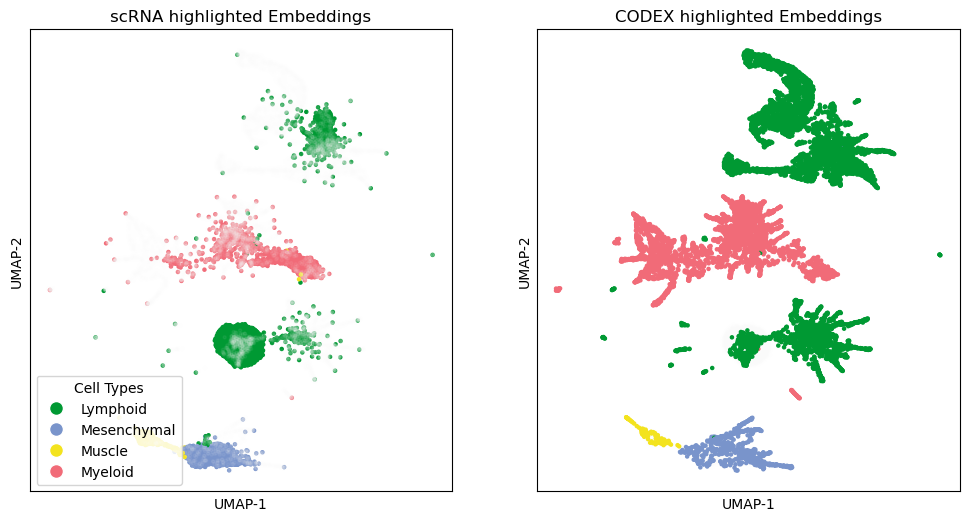

In [26]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']
datatype_array_double = np.concatenate([np.repeat(datatype[0], sum(matched_rna)), np.repeat(datatype[1], sum(matched_protein))], axis = 0)
ct_array1 = rna_adata1[matched_rna,].obs['cell_type'].values
ct_array2 = protein_adata[matched_protein].obs['cell_type'].values 
ct_array_double = np.concatenate([ct_array1, ct_array2], axis = 0)

colorbar = {'Lymphoid': np.array([0, 0.6, 0.2, 1.0]),
 'Mesenchymal': np.array([0.47265625, 0.58203125, 0.796875  , 1.        ]),
 'Muscle': np.array([0.953125 , 0.890625 , 0.1171875, 1.       ]),
 'Myeloid': np.array([0.9453125 , 0.41796875, 0.46875   , 1.        ])}
    
color_points = np.array([colorbar[i] for i in ct_array_double])

dts = np.unique(datatype_array_double)
color_datatype = ["#FFA500", "#004D99"]
colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.98, 0.98, 0.98, 0.05])[np.newaxis, :]

protein_id_umap = np.array(range(0, len(ct_array1)))
rna_id_umap = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id_umap, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id_umap, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                            markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")
#plt.gca().add_artist(legend1)
#axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])

plt.show()


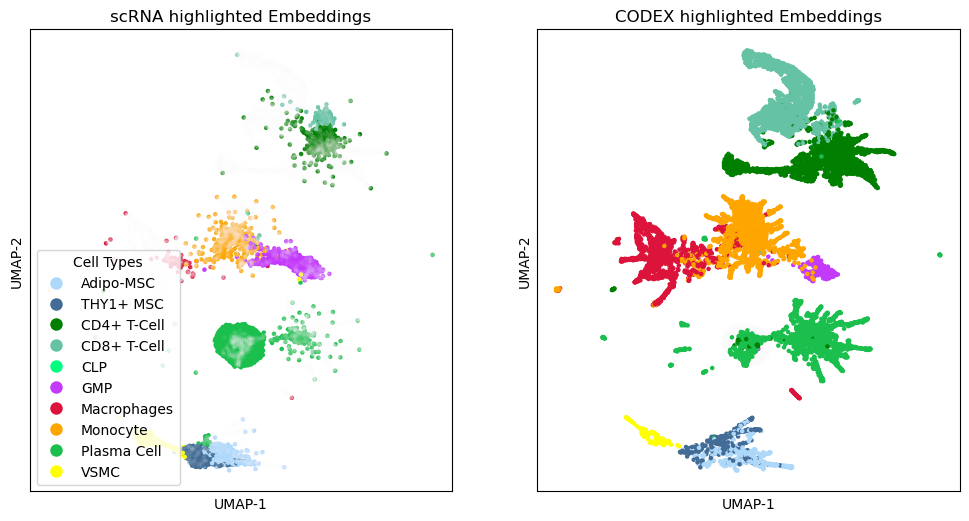

In [27]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']

ct_array1 = rna_adata1[matched_rna,].obs['cell_subtype'].values
ct_array2 = protein_adata[matched_protein].obs['cell_subtype'].values 
ct_array_double = np.concatenate([ct_array1, ct_array2], axis = 0)

colorbar = {
    'Adipo-MSC': np.array([0.67843137, 0.84705882, 0.98039216, 1.]),  # Sky Blue
    'THY1+ MSC': np.array([0.25882353, 0.41960784, 0.58431373, 1.]),  # Darker blue
    'CD4+ T-Cell': np.array([0.0, 0.49803922, 0.0, 1.]),  # Dark green
    'CD8+ T-Cell': np.array([0.4, 0.76078431, 0.64705882, 1.]),  # Lighter green, similar but distinct from CD4+
    'CLP': np.array([0.0, 1.0, 0.49803922, 1.]),  # Brighter green, stands out more
    'GMP': np.array([0.76862745, 0.22745098, 0.98039216, 1.]),  # Red-Purple, distinctive yet in the red spectrum
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.]),  # Bright red
    'Plasma Cell': np.array([0.1, 0.75098039, 0.3, 1.]),  # Unique shade of green, lighter than CD4+
    'VSMC': np.array([1.0, 1.0, 0.0, 1.])  # Yellow
}
    
color_points = np.array([colorbar[i] for i in ct_array_double])

# dts = np.unique(datatype_array_double)
# color_datatype = ["#FFA500", "#004D99"]
# colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
# color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.98, 0.98, 0.98, 0.05])[np.newaxis, :]

protein_id_umap = np.array(range(0, len(ct_array1)))
rna_id_umap = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id_umap, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id_umap, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                            markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")
#plt.gca().add_artist(legend1)
#axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])

plt.show()


In [31]:
protein_source_ct_array = np.array(ct_anno_df['sct'])
protein_predict_ct_array = np.array(ct_anno_df['pct'])

In [32]:
non_zero_rows = protein_source_ct_array == protein_predict_ct_array

## Marker-based validation of conflicted populations
Define conflict cohorts (cells whose predicted subtype differs from original) and subset matched cells. Use canonical markers (CD4, CD8A/B, THY1, CD34, CD38, CD14, CD68, CD163, HLA-DRA) to distinguish probable mislabels (marker patterns contradict original subtype) from biologically intermediate states.

Strategy:
1. Construct boolean index arrays for each salient off‑diagonal pair (e.g., CD4→CD8 disagreement) to simplify downstream filtering.
2. Enumerate combinatorial marker presence/absence patterns; compare against expected immunophenotypes (e.g., true CD8 lineage should co‑express CD8A & CD8B and often lower CD4).
3. Quantify “mislabel ratio” = counts of marker configurations incompatible with original annotation / total conflict cells.


In [34]:
cd4ID = (rna_source_ct_array == 'CD4+ T-Cell') & (rna_predict_ct_array == 'CD8+ T-Cell')
cd8ID = (rna_source_ct_array == 'CD8+ T-Cell') & (rna_predict_ct_array == 'CD4+ T-Cell')
adipoID = (rna_source_ct_array == 'Adipo-MSC') & (rna_predict_ct_array == 'THY1+ MSC')
thy1ID = (rna_source_ct_array == 'THY1+ MSC') & (rna_predict_ct_array == 'Adipo-MSC')
gmpID = (rna_source_ct_array == 'GMP') & (rna_predict_ct_array == 'Monocyte')
macroID = (rna_source_ct_array == 'Macrophages') & (rna_predict_ct_array == 'Monocyte')

In [35]:
cd4PID = (protein_source_ct_array == 'CD4+ T-Cell') & (protein_predict_ct_array == 'CD8+ T-Cell')
cd8PID = (protein_source_ct_array == 'CD8+ T-Cell') & (protein_predict_ct_array == 'CD4+ T-Cell')
adipoPID = (protein_source_ct_array == 'Adipo-MSC') & (protein_predict_ct_array == 'THY1+ MSC')
thy1PID = (protein_source_ct_array == 'THY1+ MSC') & (protein_predict_ct_array == 'Adipo-MSC')

In [36]:
rr = rna_adata1[rna_id]
pp = protein_adata[protein_id]
rr1 = rna_shared[rna_id]
pp1 = protein_shared[protein_id]
#pp[(pp.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID)]

Example: CD4 vs CD8 T cells. 

Among cells annotated as CD4 but predicted as CD8, evaluate CD8A/CD8B co-expression with or without CD4. High CD8A/B with diminished CD4 supports original annotation error over alignment error (Similar logic can extend to other subtype pairs using the boolean IDs obtained above).

In [37]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))
#

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0)))

1
2
0
149
111
47
23
254


In [39]:
group1 = (
    np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X > 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X > 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X > 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X > 0))
)

group2 = (
    np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X == 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X == 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X > 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X == 0))
  + np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8A'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD8B'].X == 0) &
           (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & cd4ID, 'CD4'].X == 0))
)

ratio = group2 / (group1 + group2)
print('Wrong label ratio =', ratio)

Wrong label ratio = 0.7410562180579217


The obtained ratio indicates a substantial fraction of conflict cells exhibit marker configurations inconsistent with their original labels, implying notable annotation noise in the starting metadata rather than systematic CelLink failure. 

## Biological ambiguity example
Monocyte / Macrophage axis. Use progenitor (CD34, CD38) and differentiation / activation markers (CD14, CD68, CD163, HLA-DRA) to separate clear annotation errors (e.g., GMP lacking progenitor markers yet expressing mature effector markers) from a genuine Monocyte–Macrophage continuum with graded marker expression, illustrating biologically transitional states revealed by cross-modal conflicts.


In [40]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (adipoID), 'THY1'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (adipoID), 'THY1'].X > 0))

0
0


In [42]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'Monocyte') , 'CD34'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD38'].X > 0)))

111


In [43]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X > 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X > 0))

270
64
153


In [44]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD163'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD163'].X > 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD14'].X > 0))

25
0
2


In [45]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'HLA-DRA'].X > 0)& \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X == 0)))

0
0
16
13
9


In [46]:
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X))

0.27172196
0.52885413
0.596969
0.43439707
1.1342174
0.37734252


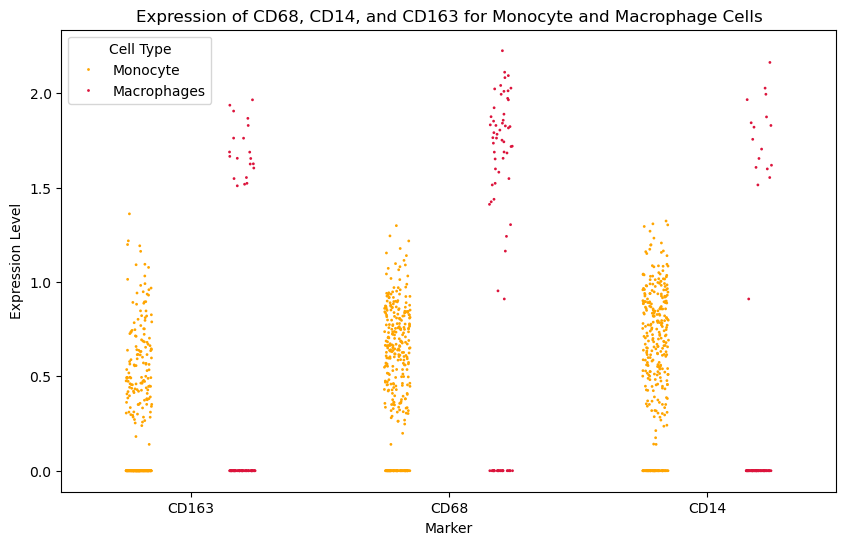

In [47]:
monocyte_cd163 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X.flatten()
monocyte_cd68 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X.flatten()
monocyte_cd14 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X.flatten()

macrophage_cd163 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X.flatten()
macrophage_cd68 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X.flatten()
macrophage_cd14 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X.flatten()

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Expression': np.concatenate([monocyte_cd163, monocyte_cd68, monocyte_cd14, macrophage_cd163, macrophage_cd68, macrophage_cd14]),
    'Marker': ['CD163'] * len(monocyte_cd163) + ['CD68'] * len(monocyte_cd68) + ['CD14'] * len(monocyte_cd14) +
              ['CD163'] * len(macrophage_cd163) + ['CD68'] * len(macrophage_cd68) + ['CD14'] * len(macrophage_cd14),
    'Cell Type': ['Monocyte'] * (len(monocyte_cd163) + len(monocyte_cd68) + len(monocyte_cd14)) +
                 ['Macrophages'] * (len(macrophage_cd163) + len(macrophage_cd68) + len(macrophage_cd14))
})

# Plot the box plot using seaborn
custom_palette = {
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.])  # Orange
}

# Plot the swarm plot using seaborn with custom colors
plt.figure(figsize=(10, 6))
sns.stripplot(x='Marker', y='Expression', hue='Cell Type', data=data, palette=custom_palette, dodge=True, size=2)

# Customize the plot
plt.title('Expression of CD68, CD14, and CD163 for Monocyte and Macrophage Cells')
plt.xlabel('Marker')
plt.ylabel('Expression Level')

plt.show()

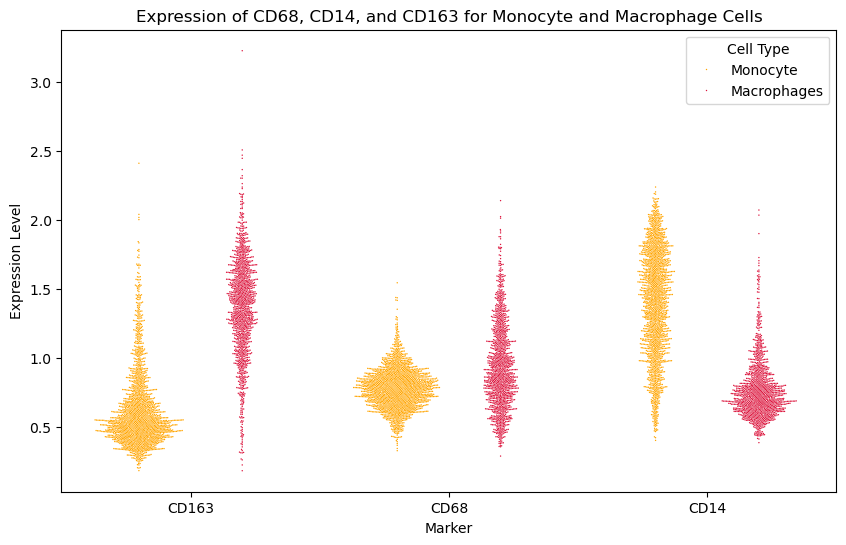

In [48]:
monocyte_cd163 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X.flatten()
monocyte_cd68 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X.flatten()
monocyte_cd14 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X.flatten()

macrophage_cd163 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X.flatten()
macrophage_cd68 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X.flatten()
macrophage_cd14 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X.flatten()

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Expression': np.concatenate([monocyte_cd163, monocyte_cd68, monocyte_cd14, macrophage_cd163, macrophage_cd68, macrophage_cd14]),
    'Marker': ['CD163'] * len(monocyte_cd163) + ['CD68'] * len(monocyte_cd68) + ['CD14'] * len(monocyte_cd14) +
              ['CD163'] * len(macrophage_cd163) + ['CD68'] * len(macrophage_cd68) + ['CD14'] * len(macrophage_cd14),
    'Cell Type': ['Monocyte'] * (len(monocyte_cd163) + len(monocyte_cd68) + len(monocyte_cd14)) +
                 ['Macrophages'] * (len(macrophage_cd163) + len(macrophage_cd68) + len(macrophage_cd14))
})

# Plot the box plot using seaborn
custom_palette = {
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.])  # Orange
}

plt.figure(figsize=(10, 6))
sns.swarmplot(x='Marker', y='Expression', hue='Cell Type', data=data, palette = custom_palette, dodge=True, size=1) 

# Customize the plot
plt.title('Expression of CD68, CD14, and CD163 for Monocyte and Macrophage Cells')
plt.xlabel('Marker')
plt.ylabel('Expression Level')

plt.show()

In this case, the apparent “prediction inconsistency” of CelLink likely reflects genuine molecular proximity between related states rather than label failure. CelLink uncovers these continua by permitting probabilistic mass sharing instead of forcing hard one‑to‑one matches.